### Helper functions

In [1]:
# For Audio:
# pip install pydub ffmpeg      ---> required
# sudo apt-get install ffmpeg   ---> optional

# For MIDI:
# pip install mido              ---> required

from pydub import AudioSegment 

def match_target_amplitude(sound, target_dBFS=-14): # default YouTube audio normalization level
    '''
    https://stackoverflow.com/questions/42492246/how-to-normalize-the-volume-of-an-audio-file-in-python-any-packages-currently-a
    '''
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)


def detect_leading_silence(sound, silence_threshold=-25.0, chunk_size=50):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms
    iterate over chunks until you find the first one with sound
    https://stackoverflow.com/questions/29547218/remove-silence-at-the-beginning-and-at-the-end-of-wave-files-with-pydub
    '''
    trim_ms = 0 # ms
    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

def trim_silence(sound, silence_threshold=-50, chunk_size=10):
    start_trim = detect_leading_silence(sound)
    end_trim = 0 # <- Do not trim the end   For trimming -> #detect_leading_silence(sound.reverse())
    duration = len(sound)    
    trimmed_sound = sound[start_trim:duration-end_trim]
    return trimmed_sound

In [2]:
import numpy

def get_sound_features(filepath, normalization=False, trimming=False):
    sound = AudioSegment.from_wav(filepath)
    if normalization:
        sound = match_target_amplitude(sound)
    if trimming:
        sound = trim_silence(sound, chunk_size=50) 
    return numpy.array(sound.get_array_of_samples())

### Data loading

In [3]:
from os import path
from mido import MidiFile 

data_path = "../data/multimodal/"
notes = ["C", "G"]
files = [("wav", "Laser"), 
         ("wav", "Sound"),
         ("mid", "MIDI")]

# READING

def read_wav(file_path):
    return get_sound_features(file_path)

def read_midi(file_path):
    elapsed = 0 # time in seconds
    midi = MidiFile(file_path)
    samples = None
    SAMPLE_RATE = 44100 # Hertz
    prev_velocity = 0
    for msg in midi:
        if msg.is_meta:
            # ignore meta messages, they should be of length 0 leading to no samples generated
            velocity = -1 
        else:
            velocity = msg.velocity
        length = msg.time
        elapsed += length
        samples_expected = int(numpy.round(elapsed * SAMPLE_RATE))
        if samples is None:
            samples = numpy.full(samples_expected, prev_velocity)
        else:
            samples_to_insert = samples_expected - len(samples)
            # inserting samples of same velocity
            curr_samples = numpy.full(samples_to_insert, prev_velocity)
            samples = numpy.concatenate((samples, curr_samples))
        prev_velocity = velocity
    return samples
        
read_function = {"wav" : read_wav,
                 "mid" : read_midi}

# POST_PROCESSING

def process_midi(midi, sound):
    # adding missing silence at midi data
    sound_length = len(sound)
    missing_length = sound_length - len(midi)
    if missing_length > 0:
        curr_samples = numpy.full(missing_length, 0) # zero velocity
        midi = numpy.concatenate((midi, curr_samples))
    return midi

def clamp_pwm(x):
    # converts analog signal into digital by clamping to 0/1 according to threshold
    x = x / x.max()
    #threshold = (x.max() - x.min()) / 2
    threshold = 0
    return numpy.where(x > threshold, 1, 0)

def smooth_pwm(x):
    # There are 490 PWM pulses per second, each of which encodes a measurement
    PWM_FREQUENCY = 490 # frequency of pulse width modulation, Hz
    # Calculating how many sound samples each measurement takes
    LASER_SIGNAL_WINDOW = int(44100 / PWM_FREQUENCY)  # number of samples per measurement
    x = clamp_pwm(x)
    start = 0
    is_last_0 = True
    curr_value = 0
    for i in range(len(x)):
        if x[i] == 1 and is_last_0:
            x[start : i] = curr_value
            start = i
            is_last_0 = False
            #print(last_1 + 1, i, curr_value)
        elif x[i] == 0 and not is_last_0:
            curr_value = i - start
            x[start : i] = curr_value
            start = i
            is_last_0 = True
            #print(last_1 + 1, i,curr_value)
        elif i == len(x) - 1:
            x[start : ] = curr_value
    return x / LASER_SIGNAL_WINDOW

def process_laser(laser):
    # Laser generates data as PWM-signal. 
    # To convert the encoded signal back to real laser data (demodulate the signal), 
    # we convolve the signal with fixed a fixed length box filter
    def smooth(x,window_len=11,window='hanning'):
        # https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
        if x.ndim != 1:
            raise(ValueError, "smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
            raise(ValueError, "Input vector needs to be bigger than window size.")
        if window_len<3:
            return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
            raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
        #print(len(s))
        if window == 'flat': #moving average
            w=numpy.ones(window_len,'d')
        else:
            w=eval('numpy.'+window+'(window_len)')
        y=numpy.convolve(w/w.sum(),s,mode='valid')
        return y
    return smooth_pwm(laser)

# MAIN LOADING FUNCTION

def read_data():
    # structure of data - dictionary of dictionaries:
    # { Note_name : { data_file_name : time series data} } 
    data = dict()
    for note in notes:
        data[note] = dict()
        for file_type, file_name in files:
            file_path = path.join(data_path, "{}_{}.{}".format(note, file_name, file_type))
            data[note][file_name] = read_function[file_type](file_path)
        data[note]["MIDI"] = process_midi(data[note]["MIDI"], data[note]["Sound"])
        data[note]["Laser"] = process_laser(data[note]["Laser"])
    return data

In [4]:
data = read_data()
data

{'C': {'Laser': array([0.        , 0.        , 0.        , ..., 0.24444444, 0.24444444,
         0.24444444]),
  'Sound': array([   0, 1792,  256, ...,    0,    0,    0], dtype=int32),
  'MIDI': array([0, 0, 0, ..., 0, 0, 0])},
 'G': {'Laser': array([0.        , 0.06666667, 0.06666667, ..., 0.14444444, 0.14444444,
         0.14444444]),
  'Sound': array([   0, 1024,   -1, ...,    0,    0,    0], dtype=int32),
  'MIDI': array([0, 0, 0, ..., 0, 0, 0])}}

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
def plot_time_series(Sound, Laser, Midi, title, plot_samples=44100 * 60): # 1 minute by default 
    plt.xlabel("Time sample")
    plt.ylabel("Value")
    plt.title("Multi-modal time series: {}".format(title))
    plt.plot(Sound[:plot_samples] / Sound.max(), label="Sound")
    plt.plot(Laser[:plot_samples] / Laser.max(), label="Laser")
    plt.plot(Midi[:plot_samples] / Midi.max(), label="MIDI")
    plt.legend()

Time series lengths (Note C): 19205125 19205125 19205125


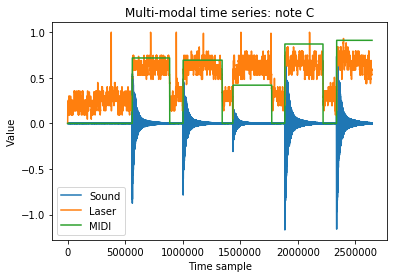

In [6]:
Sound_C, Laser_C, Midi_C = data["C"]["Sound"], data["C"]["Laser"], data["C"]["MIDI"]
print("Time series lengths (Note C):", len(Sound_C), len(Laser_C), len(Midi_C))
plot_time_series(Sound_C, Laser_C, Midi_C, "note C")

Time series lengths (Note G): 19098579 19098579 19098579


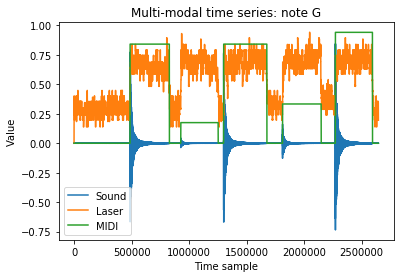

In [8]:
Sound_G, Laser_G, Midi_G = data["G"]["Sound"], data["G"]["Laser"], data["G"]["MIDI"]
print("Time series lengths (Note G):", len(Sound_G), len(Laser_G), len(Midi_G))
plot_time_series(Sound_G, Laser_G, Midi_G, "note G")

# Now we can use Laser, Sound, Midi time series to do the Machine Learning 


### Start with Laser --> Midi, which should be easiest
### I think that it should be possible to predict MIDI from few past samples of Laser (like  Laser[t-n : t] --> Midi [t], where "n" is some number)

### So we can either use supervised MLP network that will take n previous samples of Laser, and predict current sample of Midi; (as a first step)
### Or use a real RNN (as a second step)